In [25]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from preprocessing import *
from clustering import *
from plotting import *
from sklearn.metrics import silhouette_score

from pandas.tools.plotting import table

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

%matplotlib inline

In [26]:
# funcion que obtiene los indices de las estrelllas que cumplen con los criterios
def index_criterion_t(data,criterion):
    if criterion == "lineal":
        selected = np.where((np.abs(data["Q1-Q1promedio"]) > 4 ) & (data["C1"] <= 0.02)
                           & ~(np.abs(data["Q2-Q2promedio"]) > 4))
    if criterion == "parabolic":
        selected = np.where((np.abs(data["Q2-Q2promedio"]) > 4 ) & (data["C2"] <= 0.02)
                           & ~(np.abs(data["Q1-Q1promedio"]) > 4))
    if criterion == "mix":
        selected = np.where((np.abs(data["Q1-Q1promedio"]) > 4 ) & (data["C1"] <= 0.02)
                            & (np.abs(data["Q2-Q2promedio"]) > 4 ) & (data["C2"] <= 0.02))
    return selected

def stars_selection_t(data,features):

    # Se obtienen los indices de las estrellas que cumplen conlos criterios
    lineal = index_criterion_t(data,"lineal")
    print(lineal)
    parabolic = index_criterion_t(data,"parabolic")
    print(parabolic)
    mix = index_criterion_t(data,"mix")
    # Se obtienen todas las estrellas que cumplen con los criterios
    df_lineal = data.iloc[lineal]
    df_parabolic = data.iloc[parabolic]
    df_mix = data.iloc[mix]
    dataset = pd.concat([df_lineal,df_parabolic,df_mix],ignore_index=True)
    X = dataset[features]
    X_info = dataset[["Star","RA","DEC"]    ]
    #Se estandariza el dataset
    scaler = StandardScaler().fit(dataset[features])
    X_std = pd.DataFrame(scaler.transform(dataset[features]), columns=features)
    X_std_info = dataset[["Star","RA","DEC"]]
    # Se retorna la data estandarizada y la normal
    return X_std, X_std_info, X, X_info

In [27]:
hdul=fits.open('objetos_con_todo_vrad_ppm_etc.fits-plus')
t1 = Table(hdul[1].data,meta=hdul[1].header)
t2 = Table(hdul[2].data,meta=hdul[2].header)
t3 = Table(hdul[3].data,meta=hdul[3].header)
df_base = t1.to_pandas()
df_hsoy = t2.to_pandas()
df_simbad= t3.to_pandas()

#print(df_base.shape)
#print(df_hsoy.shape)
#print(df_simbad.shape)

#se corrigen errores de formato en el dataset
df_hsoy = df_hsoy.rename(columns={'Q2-Q2promedio;;;;;;;;;;;;;;;;;;;': 'Q2-Q2promedio'})
df_hsoy["Q2-Q2promedio"] = df_hsoy["Q2-Q2promedio"].apply(clean)

#Se corrige la magnitud [por el momento se reemplaza por Lbol]
#df_hsoy["Abs Mag"]= df_hsoy["Mean mag"]+5-np.log(df_hsoy["D (pc)"])

#Se agregan los valores absolutos de Q1 y Q2
df_hsoy["Abs Q1"]= np.abs(df_hsoy["Q1-Q1promedio"])
df_hsoy["Abs Q2"]= np.abs(df_hsoy["Q2-Q2promedio"])

#Se obtiene el log10 de la luminosidad en unidades solares 
df_hsoy["logLbol"]= np.log10(df_hsoy["Lbol"])

#Se calcula la magnitud de la proper motion
df_hsoy["pm"]= np.sqrt(df_hsoy["pmra"]*df_hsoy["pmra"] + df_hsoy["pmde"]*df_hsoy["pmde"])

#Pre seleccion de las features a usarpara el analisis
features_hsoy = ["logLbol","M1","Rad1","logg","D (pc)","Teff","Meta.","Abs Q1","Abs Q2","C1","C2","pm","Av"]


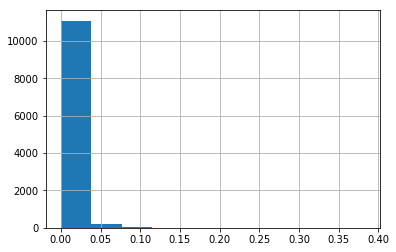

In [4]:
df_hsoy["1-C1"].hist()

In [28]:
# Estrellas selecionadas
xstd,xstd_info,x,x_info = stars_selection(df_hsoy,features_hsoy)
x.shape

(529, 13)

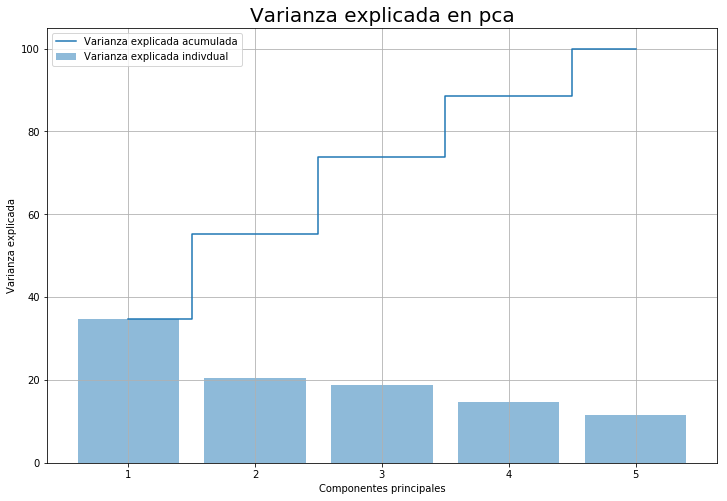

In [6]:
#test_features= ["logLbol","Teff","D (pc)","Rad2","M2","pm"]
test_features= ["Rad1","M1","pm","Teff","logLbol"]
plot_pca_explained_variance(xstd[test_features])

In [7]:
xpca,components= apply_pca(xstd[test_features],n=4)

In [29]:
dbl= apply_dbscan(xpca,2.68887,0.025)
#dbl= apply_dbscan(xpca,c,0.025)
db_cpca,db_cx,db_npca,db_nx= get_clusters(xpca,x,dbl)

###################################
#####      DBSCAN report      #####
###################################
Min samples=  13.0
Epsilon(rad)=  2.68887
Number of clusters=  1
Noise=  4  elements
Silhouette score=  0.869378541925
###################################


In [9]:
from sklearn_extensions.fuzzy_kmeans import KMedians,KMeans, FuzzyKMeans

s= []
s1=[]
s2= []
s3= []
eje_x = np.arange(2,10)
for i in eje_x:
    kmedians = KMedians(k=i)
    kmedians.fit(xpca)
    l= kmedians.labels_
    s.append(silhouette_score(xpca,l,metric='euclidean'))
    
for i in eje_x:
    kmedians = KMedians(k=i)
    kmedians.fit(db_cpca[0])
    l= kmedians.labels_
    s1.append(silhouette_score(db_cpca[0],l,metric='euclidean'))

for i in eje_x:
    km = KMeans(k=i)
    km.fit(xpca)
    l= km.labels_
    s2.append(silhouette_score(xpca,l,metric='euclidean'))
    

for i in eje_x:
    km = KMeans(k=i)
    km.fit(db_cpca[0])
    l= km.labels_
    s3.append(silhouette_score(db_cpca[0],l,metric='euclidean'))
    
    
s5= []
for i in eje_x:
    km = FuzzyKMeans(k=i)
    km.fit(db_cpca[0])
    l= km.labels_
    s5.append(silhouette_score(db_cpca[0],l,metric='euclidean'))

s4=[]
for i in eje_x:
    km = FuzzyKMeans(k=i)
    km.fit(xpca)
    l= km.labels_
    s4.append(silhouette_score(xpca,l,metric='euclidean'))

In [10]:
n0= get_k_clusters(xpca)
print(n0)
n1= get_k_clusters(db_cpca[0])

(2, [0.8835673921067555, 0.32134859012184946, 0.33070255197812765, 0.38836474383522973, 0.39231027145116132, 0.40937305058469003, 0.43892379597796255, 0.39005684391929213])


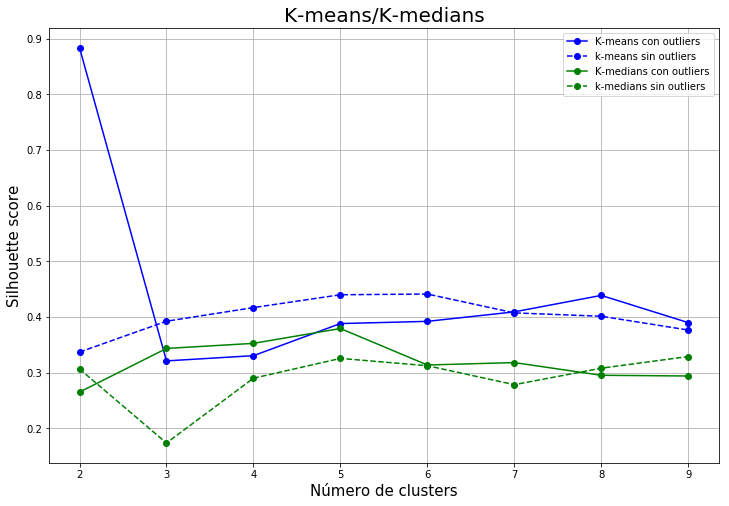

In [24]:
plt.figure(figsize=(12,8))
plt.plot(eje_x,n0[1],"o-",c="b",label="K-means con outliers")
plt.plot(eje_x,n1[1],"--o",c="b",label="k-means sin outliers")
plt.plot(eje_x,s,"o-",c="g",label="K-medians con outliers")
plt.plot(eje_x,s1,"--o",c="g",label="k-medians sin outliers")
plt.grid()
plt.legend()
plt.title("K-means/K-medians",fontsize=20)
plt.xlabel("Número de clusters",fontsize=15)
plt.ylabel("Silhouette score",fontsize=15)
plt.show()


In [12]:
#Se aplica K-MEANS sobre elcluster unico encontrado por DBSCAN
n= get_k_clusters(db_cpca[0])
print(n)
kl,c= apply_kmeans(db_cpca[0],k=n[0])

(6, [0.33716647569238817, 0.39255504613694808, 0.41699871719912368, 0.44007454417061515, 0.44135676554161452, 0.4075252451220977, 0.40146767031231018, 0.37674034579526633])
###################################
#####      KMEANS report      #####
###################################
Number of clusters=  6
Silhouette score=  0.441356765542
###################################


In [13]:
gm_score= []
x = np.arange(2,10)
for i in eje_x:
    gm= BayesianGaussianMixture(n_components=i).fit(db_cpca[0])
    labels= gm.predict(db_cpca[0])
    gm_score.append(silhouette_score(db_cpca[0],labels,metric='euclidean'))

In [14]:
print(gm_score)

[0.36908232488901244, 0.28410042289738341, 0.35433891731951322, 0.32247017365292835, 0.33054575718344725, 0.36093500692488922, 0.35296265765448809, 0.35296265765448809]


In [15]:
agg_score_eu= []
agg_score_eu2= []
agg_score_eu3= []

agg_score_manha= []
agg_score_manha2= []
for i in eje_x:
    agg1= AgglomerativeClustering(n_clusters=i,linkage="ward",affinity="euclidean")
    labels1= agg1.fit_predict(db_cpca[0])
    agg_score_eu.append(silhouette_score(db_cpca[0],labels1,metric='euclidean'))
    
    agg2= AgglomerativeClustering(n_clusters=i,linkage="average",affinity="manhattan")
    labels2= agg2.fit_predict(db_cpca[0])
    agg_score_manha.append(silhouette_score(db_cpca[0],labels2,metric='euclidean'))
    
    agg3= AgglomerativeClustering(n_clusters=i,linkage="average",affinity="euclidean")
    labels3= agg3.fit_predict(db_cpca[0])
    agg_score_eu2.append(silhouette_score(db_cpca[0],labels3,metric='euclidean'))
    
    agg4= AgglomerativeClustering(n_clusters=i,linkage="complete",affinity="euclidean")
    labels4= agg4.fit_predict(db_cpca[0])
    agg_score_eu3.append(silhouette_score(db_cpca[0],labels4,metric='euclidean'))
    
    agg5= AgglomerativeClustering(n_clusters=i,linkage="complete",affinity="manhattan")
    labels5= agg5.fit_predict(db_cpca[0])
    agg_score_manha2.append(silhouette_score(db_cpca[0],labels5,metric='euclidean'))

In [16]:
print("Euclidean")
print(agg_score_eu)
print("Euclidean 2")
print(agg_score_eu2)
print("Euclidean 3")
print(agg_score_eu3)
print("Manhatan")
print(agg_score_manha)
print("Manhatan 2" )
print(agg_score_manha2)

Euclidean
[0.33509934431383692, 0.37307606400087751, 0.38879583536074142, 0.4115458289625219, 0.41040523782491195, 0.40684574340251323, 0.40293967946442977, 0.372889469564674]
Euclidean 2
[0.52043597158274446, 0.47263310045316564, 0.42437672652026803, 0.40201336546165978, 0.35583057773563354, 0.31590581682009278, 0.37249040031783986, 0.36590510130363524]
Euclidean 3
[0.26931006676419528, 0.25493303389031086, 0.26059450321382982, 0.24204313640384426, 0.2197744679719133, 0.20022196317575749, 0.33301303492354561, 0.31531020959725109]
Manhatan
[0.56392942659054179, 0.50613907976705785, 0.44804208626500502, 0.42634436662084657, 0.37361958208322504, 0.34667173950476776, 0.37884057144786637, 0.3361355337976844]
Manhatan 2
[0.28630298504363799, 0.30577038004744356, 0.30946858465575056, 0.31049760431608936, 0.28979578430177044, 0.31963196381696851, 0.29603373105589131, 0.30975412000724095]


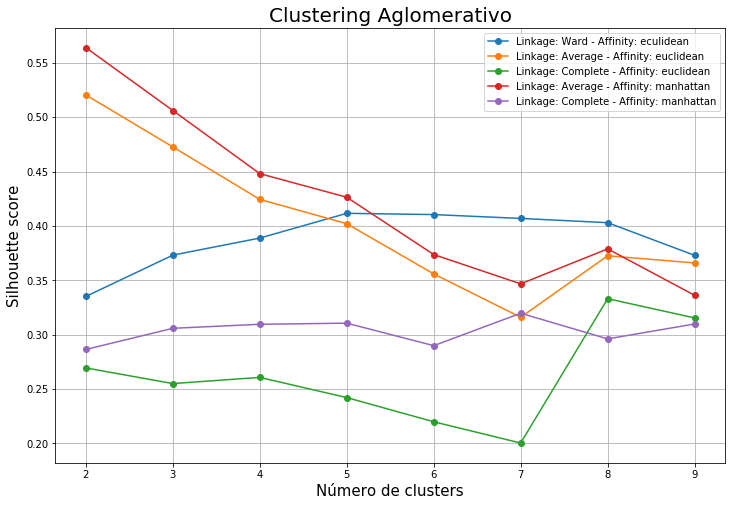

In [17]:
plt.figure(figsize=(12,8))
plt.plot(eje_x,agg_score_eu,"o-",label="Linkage: Ward - Affinity: eculidean")
plt.plot(eje_x,agg_score_eu2,"o-",label="Linkage: Average - Affinity: euclidean")
plt.plot(eje_x,agg_score_eu3,"o-",label="Linkage: Complete - Affinity: euclidean" )
plt.plot(eje_x,agg_score_manha,"o-",label="Linkage: Average - Affinity: manhattan")
plt.plot(eje_x,agg_score_manha2,"o-",label="Linkage: Complete - Affinity: manhattan")
plt.grid()
plt.legend()
plt.title("Clustering Aglomerativo",fontsize=20)
plt.xlabel("Número de clusters",fontsize=15)
plt.ylabel("Silhouette score",fontsize=15)
plt.show()


In [18]:
kl,c= apply_kmeans(db_cpca[0],k=6)
k_cpca,k_cx= get_clusters(db_cpca[0],db_cx[0],kl,r="r2")
for i in range(len(k_cx)):
    print(k_cx[i].shape)

###################################
#####      KMEANS report      #####
###################################
Number of clusters=  6
Silhouette score=  0.441356765542
###################################
(180, 13)
(178, 13)
(115, 13)
(28, 13)
(11, 13)
(13, 13)


In [19]:
aggl= apply_agg(db_cpca[0],k=2,linkage="average",affinity="Euclidean")
cpca,cx= get_clusters(db_cpca[0],db_cx[0],aggl,r="r2")

###################################
#####      Agg Report      #####
###################################
Number of clusters=  2
Linkage=  average
Affinity=  Euclidean
Silhouette score=  0.520435971583
###################################


In [20]:
for i in range(len(cx)):
    print(cx[i].shape)

(514, 13)
(11, 13)


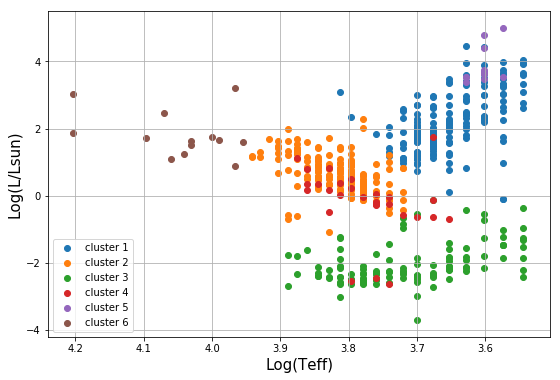

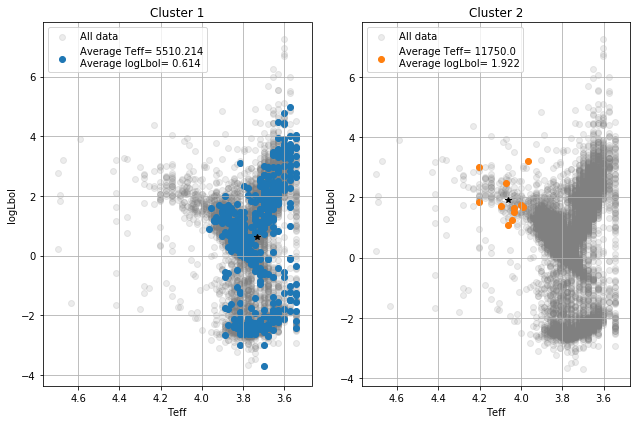

In [30]:
plot(df_hsoy,k_cx,"Teff","logLbol",semilogx=True,semilogy=False,invert_x=True,plot_all_data=False,s=(9,6))
plot_compare_clusters(df_hsoy,cx,"Teff","logLbol",semilogx=True,semilogy=False,invert_x=True,s=(9,6))

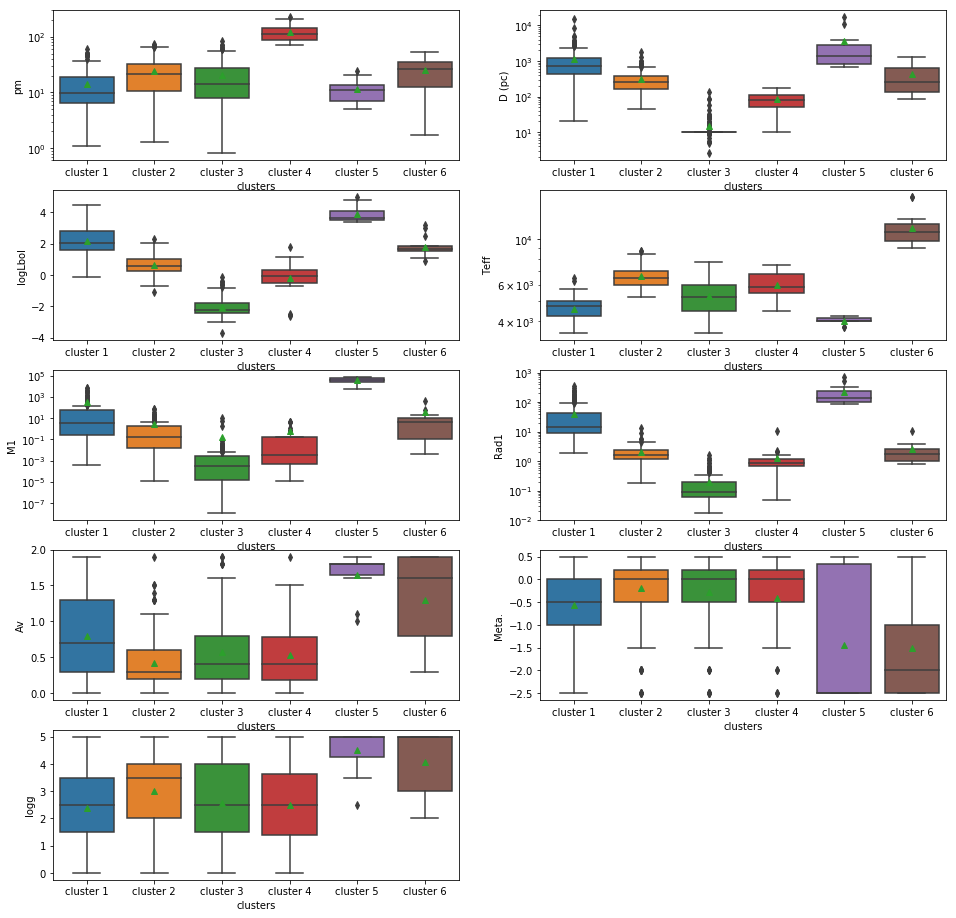

In [22]:
test_features= ["pm","D (pc)","logLbol","Teff","M1","Rad1","Av","Meta.","logg"]
plotting_boxplots_c(k_cx,test_features)

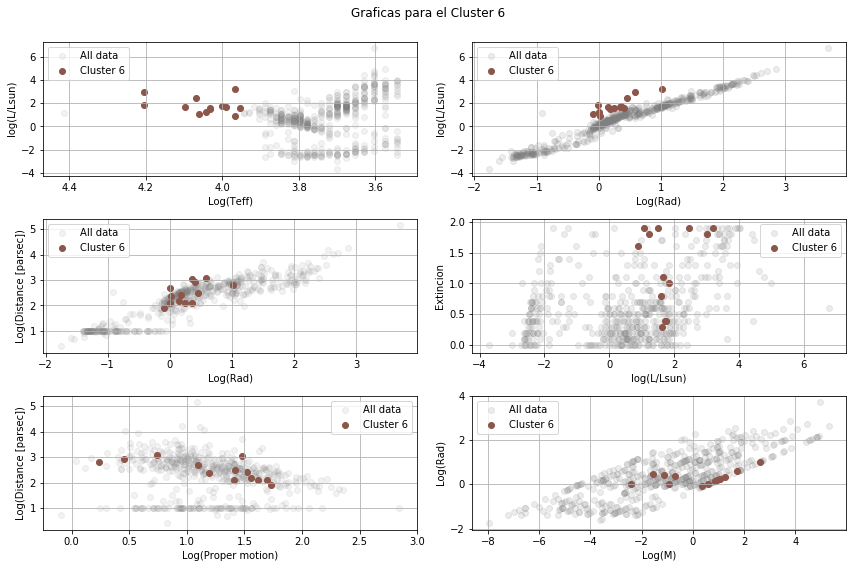

In [40]:
def names(x,flag):
    if x == "logLbol":
        y= "log(L/Lsun)"
    elif x=="logg":
        y= "Log(g)"
    elif x== "Av":
        y="Extincion"
    elif x == "Teff" and flag==True:
        y= "Log(Teff)"
    elif x== "Rad1" and flag==True:
        y= "Log(Rad)"
    elif x == "D (pc)" and flag==True:
        y= "Log(Distance [parsec])"
    elif x == "pm" and flag==True:
        y= "Log(Proper motion)"
    elif x =="M1" and flag==True:
        y= "Log(M)"
    else:
        y = x
    return y



combined_features=[("Teff","logLbol"),("Rad1","logLbol"),("Rad1","D (pc)"),("logLbol","Av"),("pm","D (pc)"),("M1","Rad1")]


def plot_compare_features(df,cluster,combined_features,s,c,title):
    fig = plt.figure(figsize=s)
    m= int(np.ceil(len(combined_features)/2))
    gs = gridspec.GridSpec(m, 2)
    #plt.suptitle("asdf")
    for i in range(m):
        if 2*i <= len(combined_features)-1:
            flagx= False
            flagy= False
            fx= combined_features[2*i][0]
            fy= combined_features[2*i][1]
            ax= fig.add_subplot(gs[i, 0])
            if fx=="D (pc)" or fx == "Rad1" or fx=="pm" or fx=="Teff" or fx == "M1":
                all_x= np.log10(df[fx])
                cx= np.log10(cluster[fx])
                flagx= True
            else:
                all_x =df[fx]
                cx= cluster[fx]
            if fy=="D (pc)" or fy== "Rad1" or fy=="pm" or fy == "Teff" or fy=="M1":
                all_y= np.log10(df[fy])
                cy= np.log10(cluster[fy])
                flagy= True
            else:
                all_y =df[fy]
                cy= cluster[fy]
            
            ax.scatter(all_x,all_y,c="gray",label="All data", alpha= 0.1)
            ax.scatter(cx,cy,c=c,label=title)
            x_title= names(fx,flagx)
            y_title= names(fy,flagy)
            ax.set_xlabel(x_title,fontsize=10)
            ax.set_ylabel(y_title,fontsize=10)
            ax.grid()
            ax.legend()
            if fx == "Teff" and fy == "logLbol":
                ax.invert_xaxis()
                
        if 2*i+1 <= len(combined_features)-1:
            flagx= False
            flagy= False
            ax= fig.add_subplot(gs[i, 1])
            fx= combined_features[2*i+1][0]
            fy= combined_features[2*i+1][1]
            if fx=="D (pc)" or fx == "Rad1" or fx=="pm" or fx=="Teff" or fx=="M1" or fx=="M2":
                all_x= np.log10(df[fx])
                cx= np.log10(cluster[fx])
                flagx= True
            else:
                all_x =df[fx]
                cx= cluster[fx]
            if fy=="D (pc)" or fy== "Rad1" or fy=="pm" or fy == "Teff" or fy =="M1" or fy =="M2":
                all_y= np.log10(df[fy])
                cy= np.log10(cluster[fy])
                flagy= True
            else:
                all_y =df[fy]
                cy= cluster[fy]
                
            ax.scatter(all_x,all_y,c="gray",label="All data", alpha= 0.15)
            ax.scatter(cx,cy,c=c,label=title)
            x_title= names(fx,flagx)
            y_title= names(fy,flagy)
            ax.set_xlabel(x_title,fontsize=10)
            ax.set_ylabel(y_title,fontsize=10)
            ax.grid()
            ax.legend()
            if fx == "Teff" and fy == "logLbol":
                ax.invert_xaxis()
    plt.suptitle("Graficas para el "+title,fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

k=5

plot_compare_features(x,k_cx[k],combined_features,s=(12,8),c="C"+str(k),title="Cluster "+str(k+1))

In [ ]:
all_data = k_cx
table_df= pd.DataFrame()
for i in all_data:
    a= i.describe()
    a= a.iloc[1:2]
    table_df= pd.concat([a,table_df],ignore_index=True)

table_df= table_df.iloc[::-1]
for i in range(len(all_data)):
    table_df= table_df.rename({i: "Cluster"+str(len(all_data)-i)}, axis="index")
table_df

In [ ]:
nombres= ["Log(L/Lsun)","Masa","Radio","Log(g)","D","Teff","Meta","Q1","Q2","C1","C2","Pm","Av"]
table_df =  table_df.rename({"logLbol":"Log(L/Lsun)","logg":"Log(g)","M1":"Masa","Rad1":"Radio","Meta.":"Metalicidad","D (pc)":"Distancia","pm":"Movimiento propio","Av":"Extincion","Teff":"Temperatura efectiva"}, axis="columns")

In [ ]:
table_df= table_df.drop("Abs Q1",axis=1)
table_df= table_df.drop("Abs Q2",axis=1)
table_df= table_df.drop("C1",axis=1)
table_df= table_df.drop("C2",axis=1)

In [ ]:
table_df

In [ ]:
from sklearn.manifold import TSNE

xtsne0 = TSNE(n_components=2,perplexity=50).fit_transform(xstd)

In [ ]:
xtsne = TSNE(n_components=2,perplexity=50).fit_transform(xpca)

In [ ]:
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 2)
ax= fig.add_subplot(gs[0, 0])
ax.scatter(xtsne0[:,0],xtsne0[:,1],c="g")
ax.set_title("t-SNE aplicado sobre los datos normalizados",fontsize=20)
ax.set_xlabel("t-SNE 1",fontsize=15)
ax.set_ylabel("t-SNE 2",fontsize=15)
ax.grid()

ax= fig.add_subplot(gs[0, 1])
ax.scatter(xtsne[:,0],xtsne[:,1],c="r")
ax.set_title("t-SNE aplicado sobre la transformación PCA",fontsize=20)
ax.set_xlabel("t-SNE 1",fontsize=15)
ax.set_ylabel("t-SNE 2",fontsize=15)
ax.grid()